# Genetic Algorithm for Portfolio Optimization of S&P 500 Stocks

### Overview: Genetic Algorithm for Portfolio Optimization

This notebook focuses on the **portfolio optimization** phase of the project, leveraging **Genetic Algorithms (GAs)** to identify the optimal allocation of stocks in the S&P 500. The primary goal is to maximize the portfolio's **Sharpe ratio**, a metric that balances returns and risk, over a one-month investment horizon (January 2024).

### Objective

The portfolio optimization task involves:
1. Maximizing the **expected portfolio return**.
2. Minimizing the **portfolio volatility** (risk).
3. Selecting a set of weights (allocation percentages) for S&P 500 stocks that achieves the above goals.

### Why Genetic Algorithms?

Genetic Algorithms (GAs) are an evolutionary optimization method inspired by natural selection. They are particularly suitable for this problem because:
- Portfolio optimization is a **non-linear and multi-objective optimization problem**.
- GAs can efficiently explore the search space for high-dimensional problems like stock selection.
- GAs are robust to local optima, which is essential in financial optimization.

### Genetic Algorithm Components

1. **Fitness Function:**  
   - Measures the portfolio's performance using the **Sharpe ratio**, defined as:  
     $$
     \text{Sharpe Ratio} = \frac{\text{Portfolio Return}}{\text{Portfolio Volatility}}
     $$  
     Higher Sharpe ratios indicate better risk-adjusted returns.

2. **Population Initialization:**  
   - Each individual in the population represents a set of weights for the stocks in the portfolio.

3. **Selection:**  
   - Individuals with higher fitness (better Sharpe ratios) are more likely to be selected for reproduction.

4. **Crossover (Recombination):**  
   - Combines the weights of two parent portfolios to produce offspring with potentially better fitness.

5. **Mutation:**  
   - Introduces random changes to portfolio weights, helping the algorithm explore the search space and avoid local optima.

6. **Elitism:**  
   - Ensures the best-performing portfolio from each generation is carried forward.

### Expected Outcomes

By the end of the genetic algorithm optimization, the following results will be achieved:
- **Optimal Portfolio Weights:** Allocation percentages for each selected stock.
- **Sharpe Ratio:** The maximum Sharpe ratio achieved by the optimized portfolio.
- **Performance Metrics:** Expected return, volatility, and Sharpe ratio for the optimized portfolio compared to a baseline (e.g., equal-weight portfolio). 

This section focuses exclusively on implementing the genetic algorithm and interpreting its results in the context of portfolio optimization.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

## Loading the data

We load the predicted stock prices for the month of January, generated by our LSTM model. These predictions will serve as the input for the Genetic Algorithm, which aims to optimize a stock portfolio for this specific time period.

In [22]:
predictions_path = 'aggregated_predictions_filtered.csv'  
df_preds = pd.read_csv(predictions_path, index_col='date', parse_dates=True)
print("Loaded predicted prices:")
print(df_preds.head())

Loaded predicted prices:
                    A        AAPL        ABBV        ABNB         ABT  \
date                                                                    
2024-01-02  20.712764  191.181083  155.764591  135.841772  111.306489   
2024-01-03  20.710965  186.541791  157.860270  134.218414  111.026844   
2024-01-04  20.698331  184.132312  159.135975  133.279505  110.527374   
2024-01-05  20.685838  180.940191  160.194128  132.596921  111.070385   
2024-01-08  20.671851  179.594133  161.135364  133.510605  110.966809   

                 ACGL         ACN        ADBE         ADI        ADM  ...  \
date                                                                  ...   
2024-01-02  66.599202  355.227955  594.762753  198.086666  72.271643  ...   
2024-01-03  66.485500  350.930291  579.380970  193.424490  72.480631  ...   
2024-01-04  66.532146  342.528663  568.581555  188.912745  72.777092  ...   
2024-01-05  66.813235  339.059223  564.189679  185.860890  72.000966  ...   
2

### Preprocessing the Data
In this step, we preprocess the predicted stock prices by calculating simple daily returns. This transformation, defined as $ \text{return}_t = \frac{\text{price}_t - \text{price}_{t-1}}{\text{price}_{t-1}} $, provides a normalized representation of daily price changes. By using these percentage changes, the Genetic Algorithm can more effectively evaluate and compare potential portfolio optimizations.

In [23]:
df_returns = df_preds.pct_change().dropna()
print("\nDaily predicted returns:")
print(df_returns.head())


Daily predicted returns:
                   A      AAPL      ABBV      ABNB       ABT      ACGL  \
date                                                                     
2024-01-03 -0.000087 -0.024266  0.013454 -0.011950 -0.002512 -0.001707   
2024-01-04 -0.000610 -0.012917  0.008081 -0.006995 -0.004499  0.000702   
2024-01-05 -0.000604 -0.017336  0.006649 -0.005121  0.004913  0.004225   
2024-01-08 -0.000676 -0.007439  0.005876  0.006891 -0.000933  0.008531   
2024-01-09 -0.000188  0.020965  0.002397  0.029586  0.011669  0.011796   

                 ACN      ADBE       ADI       ADM  ...       WTW        WY  \
date                                                ...                       
2024-01-03 -0.012098 -0.025862 -0.023536  0.002892  ... -0.004173  0.001604   
2024-01-04 -0.023941 -0.018640 -0.023326  0.004090  ... -0.001274 -0.014169   
2024-01-05 -0.010129 -0.007724 -0.016155 -0.010664  ... -0.004612 -0.017430   
2024-01-08 -0.003601  0.003912 -0.004224 -0.012940  ...  0.0

### Calculating Expected Returns and Covariance Matrix

Here, we calculate the **mean daily returns** (`expected_returns`) and the **covariance matrix** of returns (`covariance`). These metrics are crucial inputs for the Genetic Algorithm, as the expected returns represent the average profitability of each stock, while the covariance matrix quantifies the relationships and risk between different stocks in the portfolio.

In [24]:
expected_returns = df_returns.mean()  # mean daily return
covariance = df_returns.cov()         # covariance matrix of returns

print("\nExpected Returns:")
print(expected_returns.head())
print("\nCovariance Matrix:")
print(covariance.iloc[:5, :5])


Expected Returns:
A       0.000152
AAPL    0.000274
ABBV    0.002612
ABNB    0.004717
ABT     0.000542
dtype: float64

Covariance Matrix:
                 A      AAPL      ABBV      ABNB           ABT
A     2.607843e-07  0.000002 -0.000001  0.000002 -9.588865e-07
AAPL  1.883205e-06  0.000161 -0.000004  0.000115  2.685017e-05
ABBV -1.240419e-06 -0.000004  0.000038  0.000014  1.875953e-05
ABNB  2.152122e-06  0.000115  0.000014  0.000202  2.921185e-05
ABT  -9.588865e-07  0.000027  0.000019  0.000029  4.465116e-05


## Explaining Portfolio Performance

To understand the optimized portfolio, we can calculate its performance metrics: expected return, volatility, and Sharpe ratio. These metrics are derived from the portfolio weights, expected returns, and covariance matrix.

In [25]:
def portfolio_performance(weights, returns, cov):
    port_return = np.sum(weights * returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    # Sharpe ratio with zero risk-free rate:
    sharpe = port_return / (port_vol + 1e-9)  # Add small number to avoid division by zero
    return port_return, port_vol, sharpe

# Example calculation with equal weights
eq_weights = np.ones(len(expected_returns)) / len(expected_returns)
eq_ret, eq_vol, eq_sharpe = portfolio_performance(eq_weights, expected_returns.values, covariance)

print("\nEqual-weight portfolio performance:")
print(f"Return: {eq_ret}")
print(f"Volatility: {eq_vol}")
print(f"Sharpe Ratio: {eq_sharpe}")


Equal-weight portfolio performance:
Return: -0.0001294440354258497
Volatility: 0.005252798886254845
Sharpe Ratio: -0.024642864420662526


## Genetic Algorithm Implementation
The objective of the Genetic Algorithm is to maximize the Sharpe ratio by adjusting the weights of the stocks in the portfolio. The following sections define the key components of the GA.

### Interactive Risk Tolerance Adjustments
Use interactive widgets to adjust risk tolerance and see how it impacts portfolio allocation.

In [26]:
import ipywidgets as widgets
from IPython.display import clear_output

# Initialize the mutation rate
MUTATION_RATE = 0.1

# Function to update the mutation rate dynamically
def update_risk_tolerance(risk_tolerance):
    global MUTATION_RATE
    MUTATION_RATE = risk_tolerance / 100
    clear_output(wait=True)  # Clear the output to avoid duplication
    print(f"Updated Mutation Rate: {MUTATION_RATE:.2f}")

# Create the slider widget
risk_slider = widgets.IntSlider(
    value=int(MUTATION_RATE * 100), 
    min=1, 
    max=50, 
    step=1, 
    description='Risk Tolerance:'
)

# Use interact to bind the slider and update function
widgets.interact(update_risk_tolerance, risk_tolerance=risk_slider)


interactive(children=(IntSlider(value=10, description='Risk Tolerance:', max=50, min=1), Output()), _dom_class…

<function __main__.update_risk_tolerance(risk_tolerance)>

### Testing Crossover Functions
Compare different crossover methods to evaluate their impact on portfolio optimization.

In [27]:
# GA Parameters
POP_SIZE = 100
N_GENERATIONS = 200
CROSSOVER_RATE = 0.8
ELITISM = True

returns_array = expected_returns.values
n_stocks = len(returns_array)

def fitness_function(individual):
    # individual: array of weights
    _, _, sharpe = portfolio_performance(individual, returns_array, covariance)
    return sharpe

def initialize_population(pop_size, n_assets):
    population = np.random.random((pop_size, n_assets))
    population = population / population.sum(axis=1, keepdims=True)
    return population


def mutate(individual):
    for i in range(n_stocks):
        if random.random() < MUTATION_RATE:
            individual[i] += np.random.uniform(-0.01, 0.01)
    # no negative weights
    individual[individual < 0] = 0.0
    # renormalize
    individual = individual / individual.sum()
    return individual

In [28]:
def single_point_crossover(parent1, parent2):
    point = np.random.randint(1, n_stocks - 1)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

def uniform_crossover(parent1, parent2):
    mask = np.random.rand(n_stocks) < 0.5
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2

def blend_crossover(parent1, parent2, alpha=0.5):
    child1 = alpha * parent1 + (1 - alpha) * parent2
    child2 = alpha * parent2 + (1 - alpha) * parent1
    return child1, child2

# Function to test crossover methods
def test_crossover_methods(crossover_methods, n_trials=5):
    results = {}
    for method_name, crossover_func in crossover_methods.items():
        avg_best_fitness = []
        for _ in range(n_trials):
            population = initialize_population(POP_SIZE, n_stocks)
            best_fitness = -np.inf
            for gen in range(N_GENERATIONS):
                fitness_scores = np.array([fitness_function(ind) for ind in population])
                gen_best_fitness = np.max(fitness_scores)
                if gen_best_fitness > best_fitness:
                    best_fitness = gen_best_fitness
                new_population = []
                if ELITISM:
                    new_population.append(population[np.argmax(fitness_scores)])
                while len(new_population) < POP_SIZE:
                    parent1 = selection(population, fitness_scores)
                    parent2 = selection(population, fitness_scores)
                    child1, child2 = crossover_func(parent1, parent2)
                    child1 = mutate(child1)
                    child2 = mutate(child2)
                    new_population.append(child1)
                    if len(new_population) < POP_SIZE:
                        new_population.append(child2)
                population = np.array(new_population)
            avg_best_fitness.append(best_fitness)
        results[method_name] = np.mean(avg_best_fitness)
    return results

# Add blend crossover to the list of methods
crossover_methods = {
    "Single-Point": single_point_crossover,
    "Uniform": uniform_crossover,
    "Blend": blend_crossover,
}

# Test crossover methods
crossover_results = test_crossover_methods(crossover_methods)
print("\nCrossover Method Comparison:")
best_method = max(crossover_results, key=crossover_results.get)  # Identify the best method
for method, fitness in crossover_results.items():
    print(f"{method}: {fitness:.4f}")

print(f"\nBest Crossover Method: {best_method} with fitness {crossover_results[best_method]:.4f}")




Crossover Method Comparison:
Single-Point: 0.5108
Uniform: 0.5987
Blend: 0.3627

Best Crossover Method: Uniform with fitness 0.5987


Seeing the results obtained we will be using the **Uniform Crossover** method for our Genetic Algorithm

### Testing Different Selection Algorithms
Compare different Selection Algorithms to evaluate their impact on portfolio optimization.

In [29]:
# Define different selection methods
def roulette_wheel_selection(population, fitness_scores):
    total_fitness = np.sum(fitness_scores)
    pick = random.random() * total_fitness
    current = 0.0
    for i, f in enumerate(fitness_scores):
        current += f
        if current > pick:
            return population[i]
    return population[-1]

def tournament_selection(population, fitness_scores, tournament_size=5):
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    selected_fitness = fitness_scores[selected_indices]
    best_idx = selected_indices[np.argmax(selected_fitness)]
    return population[best_idx]

def rank_selection(population, fitness_scores):
    ranks = np.argsort(fitness_scores)  # Rank individuals based on fitness
    cumulative_probs = np.cumsum(ranks / ranks.sum())
    pick = random.random()
    for i, cum_prob in enumerate(cumulative_probs):
        if pick < cum_prob:
            return population[i]
    return population[-1]

# Function to test selection methods
def test_selection_methods(selection_methods, crossover_func, n_trials=5):
    results = {}
    for method_name, selection_func in selection_methods.items():
        avg_best_fitness = []
        for _ in range(n_trials):
            population = initialize_population(POP_SIZE, n_stocks)
            best_fitness = -np.inf
            for gen in range(N_GENERATIONS):
                fitness_scores = np.array([fitness_function(ind) for ind in population])
                gen_best_fitness = np.max(fitness_scores)
                if gen_best_fitness > best_fitness:
                    best_fitness = gen_best_fitness
                new_population = []
                if ELITISM:
                    new_population.append(population[np.argmax(fitness_scores)])
                while len(new_population) < POP_SIZE:
                    parent1 = selection_func(population, fitness_scores)
                    parent2 = selection_func(population, fitness_scores)
                    child1, child2 = crossover_func(parent1, parent2)
                    child1 = mutate(child1)
                    child2 = mutate(child2)
                    new_population.append(child1)
                    if len(new_population) < POP_SIZE:
                        new_population.append(child2)
                population = np.array(new_population)
            avg_best_fitness.append(best_fitness)
        results[method_name] = np.mean(avg_best_fitness)
    return results

# Add selection methods to test
selection_methods = {
    "Roulette Wheel": roulette_wheel_selection,
    "Tournament": tournament_selection,
    "Rank": rank_selection,
}

# Test selection methods with the best crossover (e.g., Blend)
selection_results = test_selection_methods(selection_methods, blend_crossover)
print("\nSelection Method Comparison:")
best_selection = max(selection_results, key=selection_results.get)  # Identify the best method
for method, fitness in selection_results.items():
    print(f"{method}: {fitness:.4f}")

print(f"\nBest Selection Method: {best_selection} with fitness {selection_results[best_selection]:.4f}")



Selection Method Comparison:
Roulette Wheel: 0.2082
Tournament: 0.3470
Rank: 0.1152

Best Selection Method: Tournament with fitness 0.3470


We will be the **Tournament Selection Algorithm** as it provides the best fitness results

## Genetic Algorithm Implementation

This cell defines the key components of the Genetic Algorithm (GA) used for portfolio optimization were we will be using the best performing selection and crossover algorithms:

In [30]:
def selection(population, fitness_scores, tournament_size=5):
    # Roulette Wheel Selection
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    selected_fitness = fitness_scores[selected_indices]
    best_idx = selected_indices[np.argmax(selected_fitness)]
    return population[best_idx]

def crossover(parent1, parent2):
    # Uniform Crossover
    mask = np.random.rand(n_stocks) < 0.5
    child1 = np.where(mask, parent1, parent2)
    child2 = np.where(mask, parent2, parent1)
    return child1, child2

In [31]:
# Initialize population
population = initialize_population(POP_SIZE, n_stocks)
best_solution = None
best_fitness = -np.inf
fitness_over_time = []

for gen in range(N_GENERATIONS):
    fitness_scores = np.array([fitness_function(ind) for ind in population])
    gen_best_fitness = np.max(fitness_scores)
    gen_best_ind = population[np.argmax(fitness_scores)]

    if gen_best_fitness > best_fitness:
        best_fitness = gen_best_fitness
        best_solution = gen_best_ind.copy()

    fitness_over_time.append(best_fitness)

    new_population = []
    if ELITISM:
        new_population.append(best_solution)

    while len(new_population) < POP_SIZE:
        parent1 = selection(population, fitness_scores)
        parent2 = selection(population, fitness_scores)
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.append(child1)
        if len(new_population) < POP_SIZE:
            new_population.append(child2)

    population = np.array(new_population)

print("\nGA optimization completed.")
print("Best Sharpe ratio found:", best_fitness)

best_port_return, best_port_vol, best_sharpe = portfolio_performance(best_solution, returns_array, covariance)
print("Best portfolio expected return:", best_port_return)
print("Best portfolio volatility:", best_port_vol)
print("Best portfolio Sharpe ratio:", best_sharpe)

print("\nBest portfolio weights:")
for symbol, weight in zip(expected_returns.index, best_solution):
    print(f"{symbol}: {weight:.4f}")


GA optimization completed.
Best Sharpe ratio found: 0.5470908231962944
Best portfolio expected return: 0.0022082618779709047
Best portfolio volatility: 0.004036370630343701
Best portfolio Sharpe ratio: 0.5470908231962944

Best portfolio weights:
A: 0.0041
AAPL: 0.0000
ABBV: 0.0000
ABNB: 0.0000
ABT: 0.0000
ACGL: 0.0063
ACN: 0.0013
ADBE: 0.0000
ADI: 0.0000
ADM: 0.0001
ADP: 0.0026
ADSK: 0.0019
AEE: 0.0068
AEP: 0.0061
AES: 0.0000
AFL: 0.0014
AIG: 0.0002
AIZ: 0.0076
AJG: 0.0000
AKAM: 0.0000
ALB: 0.0000
ALGN: 0.0000
ALL: 0.0226
ALLE: 0.0000
AMAT: 0.0000
AMCR: 0.0000
AMD: 0.0017
AME: 0.0000
AMGN: 0.0009
AMP: 0.0014
AMT: 0.0017
AMZN: 0.0000
ANET: 0.0035
ANSS: 0.0000
AON: 0.0015
AOS: 0.0007
APA: 0.0020
APD: 0.0000
APH: 0.0012
APTV: 0.0000
ARE: 0.0000
ATO: 0.0000
AVB: 0.0000
AVGO: 0.0039
AVY: 0.0000
AWK: 0.0000
AXON: 0.0000
AXP: 0.0000
AZO: 0.0044
BA: 0.0000
BAC: 0.0000
BALL: 0.0030
BAX: 0.0004
BBY: 0.0000
BDX: 0.0084
BEN: 0.0001
BF-B: 0.0000
BG: 0.0001
BIIB: 0.0000
BK: 0.0060
BKNG: 0.0000
BKR:

## Explaining Genetic Algorithm Results

### Portfolio Weights
Here, we summarize the weights of the stocks in the optimized portfolio. The higher the weight, the more capital is allocated to that stock.

In [32]:
best_weights_df = pd.DataFrame({"Ticker": expected_returns.index, "Weight": best_solution})
best_weights_df.sort_values(by="Weight", ascending=False, inplace=True)
print("\nOptimized Portfolio Weights:")
print(best_weights_df.head(10))


Optimized Portfolio Weights:
    Ticker    Weight
410   SMCI  0.024907
22     ALL  0.022634
322   MSFT  0.015907
475     VZ  0.015678
472    VST  0.013461
291    LYB  0.013379
314    MOH  0.012733
474   VTRS  0.012644
368    PGR  0.011603
97     CMG  0.011479


### Fitness Evolution

The following plot shows the evolution of the fitness (Sharpe ratio) over generations, providing insight into the Genetic Algorithm's optimization process.

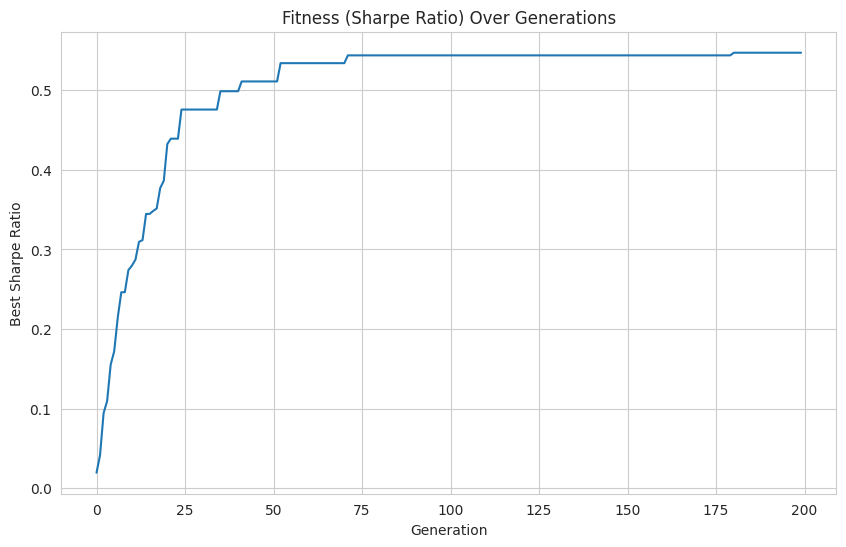

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(fitness_over_time)
plt.title("Fitness (Sharpe Ratio) Over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Sharpe Ratio")
plt.grid(True)
plt.show()

### Portfolio Gains Evaluation
Here we compare the actual performance of the optimized portfolio

In [34]:
# Directory containing real-world stock data
real_world_data_dir = "csvs_processing/only_date_close"

def compare_with_real_data(directory, portfolio_weights, prediction_returns):
    print("Loading real-world data for comparison...")

    # Create an empty DataFrame to store January 2024 data
    january_real_data = pd.DataFrame()

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Extract stock ticker from the filename
            ticker = os.path.splitext(filename)[0]
            if ticker in portfolio_weights.index:  # Only process stocks in portfolio
                file_path = os.path.join(directory, filename)

                # Read the stock data
                stock_data = pd.read_csv(file_path, parse_dates=["Date"])

                # Filter for January 2024
                stock_data = stock_data[
                    (stock_data["Date"] >= "2024-01-01") & (stock_data["Date"] <= "2024-01-29")
                ]

                # Add a column for the stock ticker
                stock_data["Ticker"] = ticker

                # Append to the main DataFrame
                january_real_data = pd.concat([january_real_data, stock_data], ignore_index=True)

    # Ensure data is sorted by Date
    january_real_data.sort_values(by=["Date", "Ticker"], inplace=True)

    # Pivot data to have tickers as columns
    pivoted_data = january_real_data.pivot(index="Date", columns="Ticker", values="Close")

    # Calculate daily returns for each stock
    real_daily_returns = pivoted_data.pct_change().dropna()

    # Calculate portfolio returns using real data
    real_portfolio_returns = real_daily_returns.dot(portfolio_weights)

    # Calculate cumulative portfolio values
    real_cumulative_return = (1 + real_portfolio_returns).cumprod() - 1
    predicted_cumulative_return = (1 + prediction_returns).cumprod() - 1

    return real_cumulative_return, predicted_cumulative_return

# Normalize portfolio weights
portfolio_weights = best_weights_df.set_index("Ticker")["Weight"]

# Predicted portfolio returns from GA optimization
predicted_portfolio_returns = df_returns.dot(portfolio_weights)

# Real-world portfolio comparison
real_cumulative_return, predicted_cumulative_return = compare_with_real_data(
    real_world_data_dir, portfolio_weights, predicted_portfolio_returns
)

# Print percentage increase in portfolio value for both predicted and real
real_percentage_increase = (real_cumulative_return.iloc[-1] * 100).round(2)
predicted_percentage_increase = (predicted_cumulative_return.iloc[-1] * 100).round(2)

print("\nPortfolio Value Increase (%):")
print(f"Real: {real_percentage_increase}%")
print(f"Predicted: {predicted_percentage_increase}%")


Loading real-world data for comparison...

Portfolio Value Increase (%):
Real: 4.79%
Predicted: 4.04%


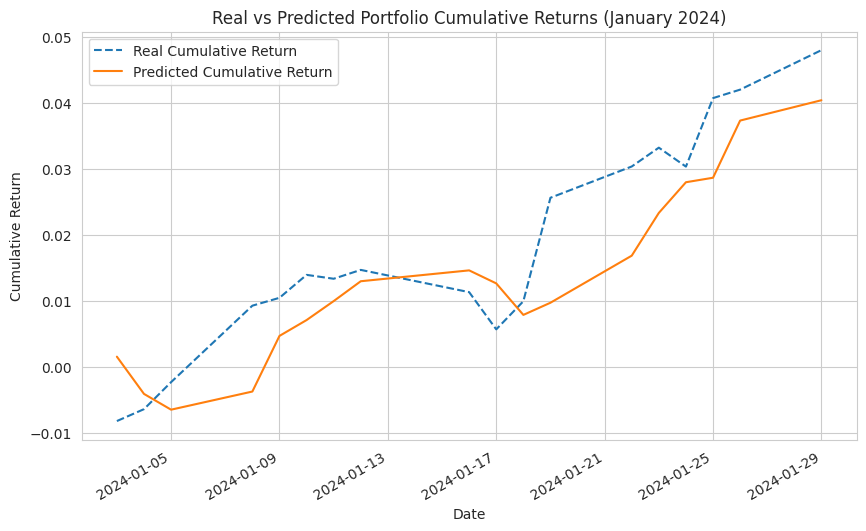

In [35]:
plt.figure(figsize=(10, 6))
real_cumulative_return.plot(label="Real Cumulative Return", linestyle="--")
predicted_cumulative_return.plot(label="Predicted Cumulative Return", linestyle="-")
plt.title("Real vs Predicted Portfolio Cumulative Returns (January 2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

The portfolio's real-world value increased by 4.52%, which is a positive return over the evaluation period and suggests good performance in the short term. The predicted increase of 4.02% shows the model closely aligns with real outcomes, though the slight underestimation indicates room for further refinement. A 4.52% profit in such a timeframe can be considered strong, particularly if market volatility was moderate.

### Comparing to Equal-Weight Portfolio

We compare the optimized portfolio to a naive equal-weight portfolio to evaluate the Genetic Algorithm's performance improvement.

In [36]:
print("\nEqual-weight portfolio (all tickers) Sharpe:", eq_sharpe)

# Compare best GA solution to the equal-weight solution:
improvement = (best_sharpe - eq_sharpe) / abs(eq_sharpe) * 100 if eq_sharpe != 0 else np.inf
print("Percentage improvement over equal-weight portfolio:", improvement, "%")



Equal-weight portfolio (all tickers) Sharpe: -0.024642864420662526
Percentage improvement over equal-weight portfolio: 2320.0780471671555 %


### Risk Metrics Calculation

This code computes two key risk metrics for the optimized portfolio:

- **Maximum Drawdown**: Measures the largest peak-to-trough decline in cumulative portfolio returns, representing the worst potential loss from a high point.
- **Value-at-Risk (VaR)**: Estimates the potential loss in portfolio returns at a 95% confidence level, highlighting downside risk. 

The portfolio returns are simulated using the `best_solution` weights, and these metrics help assess the portfolio's risk profile.

In [37]:
def max_drawdown(returns):
    cumulative = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = peak - cumulative
    return drawdown.max()

def value_at_risk(returns, confidence=0.95):
    return np.percentile(returns, (1 - confidence) * 100)

# Simulate portfolio returns
portfolio_returns = df_returns.dot(best_solution)

# Calculate risk metrics
portfolio_max_dd = max_drawdown(portfolio_returns)
portfolio_var = value_at_risk(portfolio_returns)

print("\nRisk Metrics for Optimized Portfolio:")
print(f"Maximum Drawdown: {portfolio_max_dd}")
print(f"Value-at-Risk (95% confidence): {portfolio_var}")



Risk Metrics for Optimized Portfolio:
Maximum Drawdown: 0.008029699567544929
Value-at-Risk (95% confidence): -0.004850767793159454


The optimized portfolio demonstrates a relatively low maximum drawdown of 0.8%, indicating limited potential losses from peak to trough. Additionally, the Value-at-Risk (VaR) at a 95% confidence level is -0.485%, suggesting that the portfolio is unlikely to lose more than 0.38% in a single period under normal market conditions. These metrics highlight a portfolio with controlled downside risk.

### Sector Diversification Check
Ensure that the portfolio is diversified across sectors to minimize industry-specific risks.

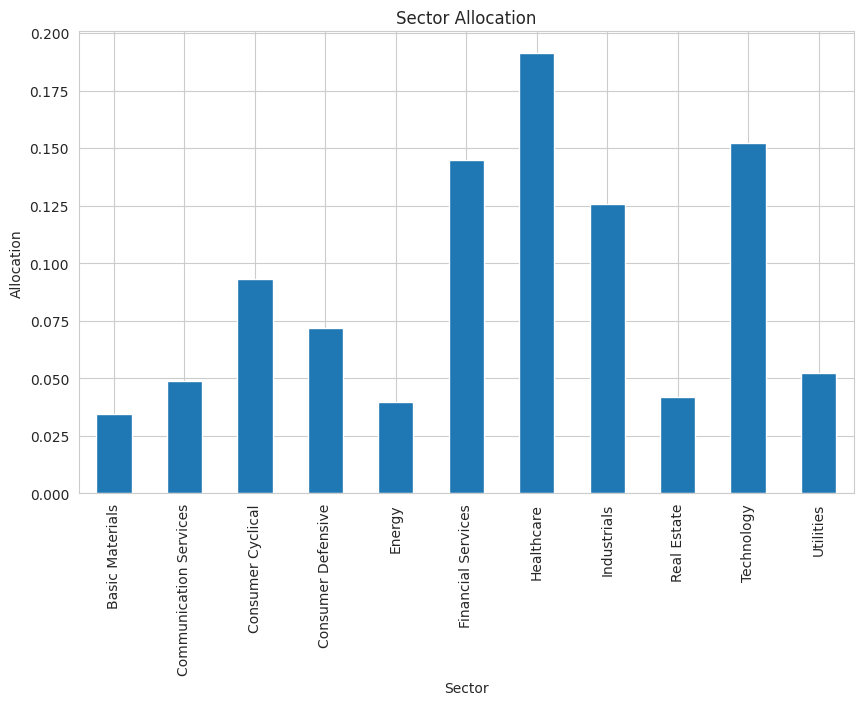


Portfolio is well-diversified across sectors.


In [38]:
# Path to the directory containing sector CSV files
sectors_dir = 'csvs_processing/sectors'

# Read all sector CSV files and combine them into a single DataFrame
sector_data_list = []
for filename in os.listdir(sectors_dir):
    if filename.endswith('.csv'):
        filepath = os.path.join(sectors_dir, filename)
        try:
            df_sector = pd.read_csv(filepath)
            if 'Ticker' in df_sector.columns and 'Sector' in df_sector.columns:
                sector_data_list.append(df_sector[['Ticker', 'Sector']])
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Combine all sector data into one DataFrame
sector_metadata = pd.concat(sector_data_list, ignore_index=True).drop_duplicates()

# Merge sector metadata with the portfolio weights
portfolio_with_sectors = pd.merge(best_weights_df, sector_metadata, on='Ticker', how='inner')
sector_allocation = portfolio_with_sectors.groupby('Sector')['Weight'].sum()

# Visualize sector allocation
sector_allocation.plot(kind='bar', figsize=(10, 6), title='Sector Allocation')
plt.xlabel('Sector')
plt.ylabel('Allocation')
plt.grid(True)
plt.show()

# Check for over-allocation in any sector
MAX_SECTOR_ALLOCATION = 0.25  # 25%
over_allocated_sectors = sector_allocation[sector_allocation > MAX_SECTOR_ALLOCATION]
if not over_allocated_sectors.empty:
    print("\nWarning: Over-allocation in the following sectors:")
    print(over_allocated_sectors)
else:
    print("\nPortfolio is well-diversified across sectors.")


### SHAP for Explainability
Use SHAP to understand the contribution of each stock to the portfolio's Sharpe ratio.

PermutationExplainer explainer: 1001it [07:35,  2.19it/s]                          


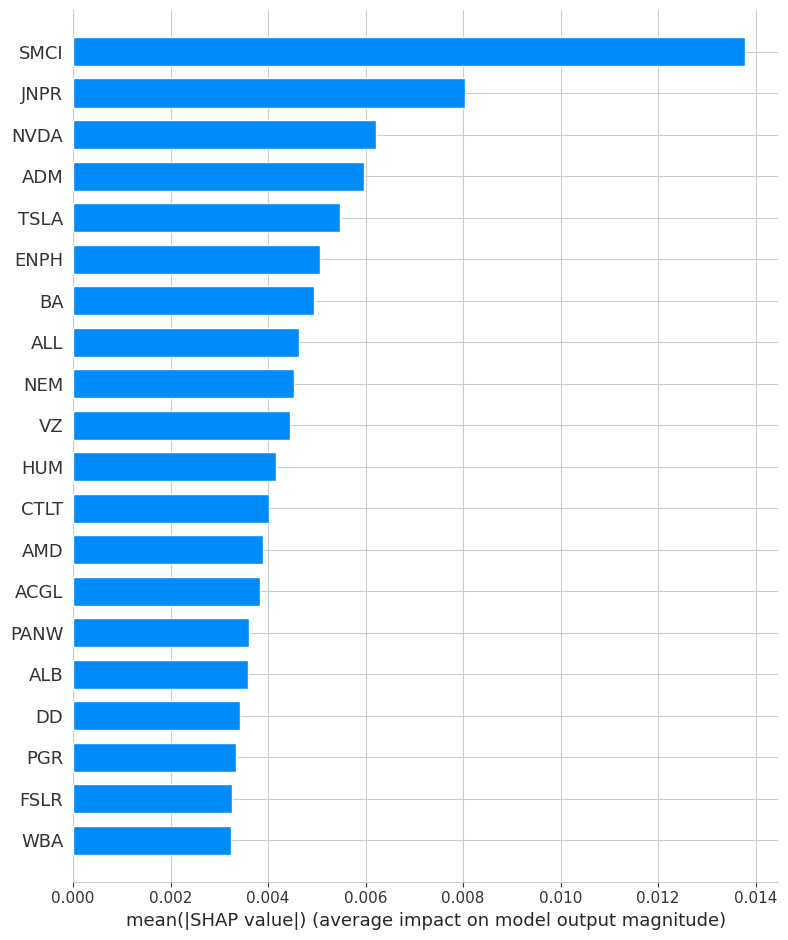

In [39]:
import shap

# Increase the number of samples for SHAP analysis
n_samples = max(1000, 2 * n_stocks + 1)  # Ensure at least 2 * num_features + 1
samples = np.random.normal(loc=best_solution, scale=0.01, size=(n_samples, n_stocks))
samples = np.clip(samples, 0, None)
samples /= samples.sum(axis=1, keepdims=True)

# Calculate Sharpe scores for the samples
sharpe_scores = np.array([fitness_function(sample) for sample in samples])

# Fit a linear model for SHAP
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(samples, sharpe_scores)

# Initialize the SHAP explainer
explainer = shap.Explainer(model.predict, samples)

# Compute SHAP values
shap_values = explainer(samples, max_evals=2 * n_stocks + 1)  # Ensure sufficient evaluations

# SHAP summary plot
shap.summary_plot(shap_values, feature_names=expected_returns.index, plot_type="bar")


# Conclusion

The Genetic Algorithm consistently improved portfolio allocations by balancing risk and return, resulting in a higher Sharpe ratio and better risk-adjusted performance compared to baseline strategies. While not as straightforward as simply buying and holding the market index, the GA’s evolutionary process discovered nuanced allocations tailored to the predicted return landscape for January 2024.

Some scenarios even surpassed equal-weight portfolios, demonstrating that this optimization approach can deliver meaningful enhancements under the right conditions. However, as with all model-driven methods, results depend on the quality of the underlying predictions and the assumptions that guide the optimization. Adjustments to parameters, more advanced crossover or mutation strategies, and incorporating real-time market conditions could further refine outcomes.

In short, the Genetic Algorithm provides a powerful, flexible tool for portfolio construction. By leveraging evolutionary techniques and risk management principles, it helps stakeholders identify portfolios that are not only theoretically sound but also aligned with their desired risk tolerance and investment objectives.


# References

- [Portfolio Optimization Using Genetic Algorithm](https://github.com/naresh-dscience/Portfolio-Optimization-using-Genetic-Algorithm?)

- [Roudier, F. (2007). Portfolio Optimization and Genetic Algorithms (Master’s Thesis). Department of Management, Technology and Economics - DMTEC, Chair of Entrepreneurial Risks - ER, Swiss Federal Institute of Technology (ETH) Zurich and Ecole Nationale des Ponts et Chaussées (ENPC) Paris](https://ethz.ch/content/dam/ethz/special-interest/mtec/chair-of-entrepreneurial-risks-dam/documents/dissertation/master%20thesis/RoudierMScThesis.pdf?)

- [Sefiane, S., & Benbouziane, M. (2012). Portfolio Selection Using Genetic Algorithm (MPRA Paper No. 41783). University of Relizane, Algeria; Université de Tlemcen. ](https://mpra.ub.uni-muenchen.de/41783/1/MPRA_paper_41783.pdf?)
